In [4]:
%%capture 
!pip install category_encoders==2.*
!pip install pandas_profiling==2.*

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 


In [6]:
train_features = pd.read_csv('/content/train_features.csv')
train_labels = pd.read_csv('/content/train_labels.csv')

train = pd.merge(train_features, train_labels)
train.head()

id  amount_tsh date_recorded funder  gps_height installer  longitude  \
0    454        50.0    2013-02-27   Dmdd        2092      DMDD  35.426020   
1    510         0.0    2011-03-17   Cmsr           0      Gove  35.510074   
2  14146         0.0    2011-07-10   Kkkt           0      KKKT  32.499866   
3  47410         0.0    2011-04-12    NaN           0       NaN  34.060484   
4   1288       300.0    2011-04-05     Ki        1023        Ki  37.032690   

   latitude                 wpt_name  num_private  ... water_quality  \
0 -4.227446                    Narmo            0  ...          soft   
1 -5.724555                   Lukali            0  ...          soft   
2 -9.081222                 Mahakama            0  ...          soft   
3 -8.830208  Shule Ya Msingi Chosi A            0  ...          soft   
4 -6.040787                Kwa Mjowe            0  ...         salty   

  quality_group      quantity  quantity_group        source   source_type  \
0          good  insufficient    insufficient        spring        spring   
1          good        enough          enough  shallow well  shallow well   
2          good        enough          enough  shallow well  shallow well   
3          good  insufficient    insufficient         river    river/lake   
4         salty        enough          enough  shallow well  shallow well   

  source_class     waterpoint_type waterpoint_type_group    status_group  
0  groundwater  communal standpipe    communal standpipe      functional  
1  groundwater           hand pump             hand pump      functional  
2  groundwater               other                 other  non functional  
3      surface  communal standpipe    communal standpipe  non functional  
4  groundwater               other                 other  non functional  

[5 rows x 41 columns]

In [7]:
def wrangle(df):
  # Set the index to 'id'
  df.set_index('id', inplace=True)

  # Drop Constant Column
  df.drop(columns='recorded_by', inplace=True)

  # Drop Duplicate Column
  df.drop(columns='quantity_group', inplace=True)

  # Drop High Cardinality Columns
  cols_to_drop = [col for col in df.select_dtypes('object') if df[col].nunique() > 100]
  df.drop(columns=cols_to_drop, inplace=True)

  # Drop columns with high proportion of zeros
  df.drop(columns='num_private', inplace=True)

  df.dropna()

  return df

train = wrangle(train)

In [8]:
ProfileReport(train);

In [9]:
train.head()

amount_tsh  gps_height  longitude  latitude        basin    region  \
id                                                                          
454          50.0        2092  35.426020 -4.227446     Internal   Manyara   
510           0.0           0  35.510074 -5.724555     Internal    Dodoma   
14146         0.0           0  32.499866 -9.081222   Lake Rukwa     Mbeya   
47410         0.0           0  34.060484 -8.830208       Rufiji     Mbeya   
1288        300.0        1023  37.032690 -6.040787  Wami / Ruvu  Morogoro   

       region_code  district_code  population public_meeting  ...  \
id                                                            ...   
454             21              1         160           True  ...   
510              1              6           0           True  ...   
14146           12              6           0           True  ...   
47410           12              7           0           True  ...   
1288             5              1         120           True  ...   

      payment_type water_quality  quality_group      quantity        source  \
id                                                                            
454     per bucket          soft           good  insufficient        spring   
510      never pay          soft           good        enough  shallow well   
14146    never pay          soft           good        enough  shallow well   
47410      monthly          soft           good  insufficient         river   
1288    on failure         salty          salty        enough  shallow well   

        source_type source_class     waterpoint_type waterpoint_type_group  \
id                                                                           
454          spring  groundwater  communal standpipe    communal standpipe   
510    shallow well  groundwater           hand pump             hand pump   
14146  shallow well  groundwater               other                 other   
47410    river/lake      surface  communal standpipe    communal standpipe   
1288   shallow well  groundwater               other                 other   

         status_group  
id                     
454        functional  
510        functional  
14146  non functional  
47410  non functional  
1288   non functional  

[5 rows x 29 columns]

In [10]:
target = 'status_group'
y = train[target]
X = train.drop(columns=target)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size= .2, random_state = 42)

In [12]:
baseline = y_train.value_counts(normalize = True)
print("The baseline is:", baseline.max())

The baseline is: 0.5440867003367004


In [13]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names= True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(max_iter= 200)
)
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity', 'source',
                                     'source_type', 'source_class',
                                     'waterpoint_type',
                                     'waterpoint_type_group'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=200))])

In [14]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42)
)
model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe             2
communal standpipe multiple    3
other                          4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -

In [15]:
from sklearn.ensemble import RandomForestClassifier

model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state= 42, n_jobs= -1, max_samples= .4, n_estimators= 150)
)
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
other                          4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 

In [16]:
print('model_lr accuracy score for training',model_rf.score(X_train,y_train))
print('model_lr accuracy score for val', model_rf.score(X_val,y_val))

model_lr accuracy score for training 0.9294770622895623
model_lr accuracy score for val 0.8102904040404041


In [17]:
from numpy.ma.core import arange
train_arr = []
val_arr = []
sample = arange(0,500,50)

for i in sample:
  tuned = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      RandomForestClassifier(random_state= 42, n_jobs= -1, max_samples= .4, n_estimators= i)
  )
tuned.fit(X_train,y_train)
train_arr.append(tuned.score(X_train,y_train))
val_arr.append(tuned.score(X_val,y_val))

In [18]:
print('model_lr accuracy score for training',model_lr.score(X_train,y_train))
print('model_lr accuracy score for val', model_lr.score(X_val,y_val))

model_lr accuracy score for training 0.7337962962962963
model_lr accuracy score for val 0.7361111111111112


In [19]:
print('model_dt accuracy score for training', model_dt.score(X_train,y_train))
print('model_dt accuracy score for val',model_dt.score(X_val,y_val) )

model_dt accuracy score for training 0.9952388468013468
model_dt accuracy score for val 0.7551557239057239


In [23]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state= 42, n_jobs= -1)
)

In [29]:
param_grid = {
    'randomforestclassifier__max_depth': range(5, 40, 5),
    'randomforestclassifier__n_estimators': range(25, 125, 25),
    'simpleimputer__strategy' : ['mean', 'median']
}

In [30]:
model_rf_grid = GridSearchCV(
    model_rf,
    param_grid = param_grid,
    n_jobs=-1,
    cv=5,
    verbose=1
)
model_rf_grid.fit(X,y)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(5, 40, 5),
                         'randomforestclassifier__n_estimators': range(25, 125, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [31]:
model_rf_grid.best_estimator_

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe multiple    4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 

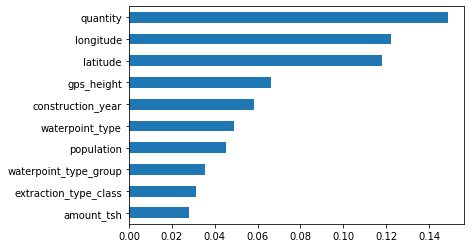

In [33]:
estimators = model_rf_grid.best_estimator_
importances = estimators.named_steps['randomforestclassifier'].feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')

In [35]:
X_test = pd.read_csv('/content/test_features.csv')
X_test = wrangle(X_test)

predictions = pd.DataFrame(data=model_rf_grid.predict(X_test), index=X_test.index)
predictions.columns = ['status_group']

In [36]:
predictions.head()

status_group
id                   
37098  non functional
14530      functional
62607      functional
46053  non functional
47083      functional

In [37]:
predictions.to_csv('my_submission.csv')

In [38]:
from google.colab import files
files.download("my_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [100]:
ProfileReport(train);

Summarize dataset:   0%|          | 0/43 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]